# Add Bookie Odds to `games_df`

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

This notebook creates a df, games_df, that is a merge of the game_df from the otehr notebook with the coresponding implied bookie odds for each game/row.  Bookie odds are averaged between all available bookie odds, 15 bookies in total.

## Create gdf

In [2]:
# Read the DataFrame constructed as game_df.

gdf = pd.read_pickle('oct_23.pkl')

In [3]:
# Get just the rows from game_df in saeson 2016.

gdf.tourney_date = pd.to_datetime(gdf.tourney_date)
gdf = gdf.loc[(gdf.tourney_date >= datetime.date(month=1, year=2016, day=1)) & 
             (gdf.tourney_date <= datetime.date(month=1, year=2017, day=1))]

In [4]:
# Helper fxn.

def convert_name(full_name):
    """
    Convert First/Last name combo to Last Name, First Initial.
    E.g. Roger Federer --> Federer R.
    """
    x = full_name.split()
    return x[1].title() + " " + x[0][0].upper() + "."

In [5]:
# Now apply name conversion to all of gdf.

gdf['player1_name'] = gdf.player1_name.apply(convert_name)
gdf['player2_name'] = gdf.player2_name.apply(convert_name);

In [6]:
#### The case where player1 / player2 tuples DO match up.

gdf['players_forward'] = gdf.player1_name + "," + gdf.player2_name
gdf.players_forward = gdf.players_forward.apply(lambda x: x.split(','))
gdf.players_forward = gdf.players_forward.apply(lambda x: tuple(x))

In [7]:
#### The case where player1 / player2 tuples DO NOT match up.

gdf['players_backward'] = gdf.player1_name + "," + gdf.player2_name
gdf.players_backward = gdf.players_backward.apply(lambda x: x.split(','))
gdf.players_backward = gdf.players_backward.apply(lambda x: tuple(x))

In [8]:
gdf.rename(columns={'tourney_name': 'tournament_name'}, inplace=True)

## Make df

In [9]:
# Read tennis odds from Kaggle Dataset

df = pd.read_csv('t_odds.csv')

In [10]:
# Get just the betting odds from all bookies, for season 2016
# Extension 1: fix 2017 data in games_df module to use 2017 as holdout

df = df[df.tournament_name.str.contains("atp")]
df = df.loc[df.doubles == 0]
df.date = pd.to_datetime(df.date)
df = df.loc[(df.date >= datetime.date(month=1, year=2016, day=1)) &
            (df.date <= datetime.date(month=1, year=2017, day=1))]

In [11]:
df = df.drop(['10bet_payout', '18bet_payout', '5dimes_payout', 'bet-at-home_payout',
         'bet365_payout', 'bethard_payout', 'betolimp_payout', 'betrally_payout',
         'bwin_payout', 'jetbull_payout', 'pinnacle_payout', 'marathonbet_payout',
         'tempobet_payout', 'tonybet_payout', 'unibet_payout'], axis=1)

In [12]:
odds_columns = ['10bet_player_1_odd',
       '10bet_player_2_odd', '18bet_player_1_odd',
       '18bet_player_2_odd', '5dimes_player_1_odd',
       '5dimes_player_2_odd', 'bet-at-home_player_1_odd',
       'bet-at-home_player_2_odd', 'bet365_player_1_odd',
       'bet365_player_2_odd', 'bethard_player_1_odd',
       'bethard_player_2_odd', 'betolimp_player_1_odd',
       'betolimp_player_2_odd', 'betrally_player_1_odd',
       'betrally_player_2_odd', 'bwin_player_1_odd',
       'bwin_player_2_odd', 'jetbull_player_1_odd',
       'jetbull_player_2_odd',
       'marathonbet_player_1_odd', 'marathonbet_player_2_odd',
       'pinnacle_player_1_odd', 'pinnacle_player_2_odd',
       'tempobet_player_1_odd', 'tempobet_player_2_odd',
       'tonybet_player_1_odd', 'tonybet_player_2_odd',
       'unibet_player_1_odd', 'unibet_player_2_odd']

player1_odds_columns = ['10bet_player_1_odd', '18bet_player_1_odd', '5dimes_player_1_odd',
'bet-at-home_player_1_odd', 'bet365_player_1_odd', 'bethard_player_1_odd',
'betolimp_player_1_odd', 'betrally_player_1_odd', 'bwin_player_1_odd',
'jetbull_player_1_odd', 'marathonbet_player_1_odd', 'pinnacle_player_1_odd',
'tempobet_player_1_odd', 'tonybet_player_1_odd', 'unibet_player_1_odd']

player2_odds_columns = ['10bet_player_2_odd', '18bet_player_2_odd', '5dimes_player_2_odd',
'bet-at-home_player_2_odd', 'bet365_player_2_odd', 'bethard_player_2_odd',
'betolimp_player_2_odd', 'betrally_player_2_odd', 'bwin_player_2_odd',
'jetbull_player_2_odd', 'marathonbet_player_2_odd', 'pinnacle_player_2_odd',
'tempobet_player_2_odd', 'tonybet_player_2_odd', 'unibet_player_2_odd']

In [13]:
# Helper fxn.

def implied_probability(decimal_odds):
    """
    Convert a player's decimal odds to implied probabilty.
    """
    
    return (1/decimal_odds)

In [14]:
# Convert to implied probability
for odds_column in odds_columns:
    df[odds_column] = df[odds_column].apply(implied_probability)

In [15]:
stds1 = []
stds2 = []
for i in range(len(df)):
    stds1.append(df.iloc[i][player1_odds_columns].std())
    stds2.append(df.iloc[i][player2_odds_columns].std())

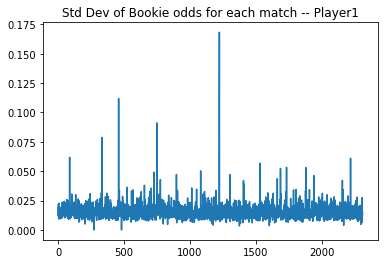

In [16]:
# Quick diversion: How much do bookies' implied odds differ?
# One plot for player1 odds, one for player2

plt.title("Std Dev of Bookie odds for each match -- Player1")
plt.plot(stds1);

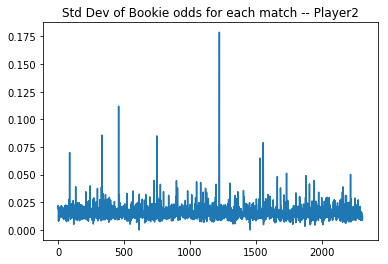

In [17]:
plt.title("Std Dev of Bookie odds for each match -- Player2")
plt.plot(stds2);

In [18]:
# Compute avg implied probability and insert into columns.
df['player1_avg_odds'] = df[player1_odds_columns].mean(axis=1)
df['player2_avg_odds'] = df[player2_odds_columns].mean(axis=1)

# Drop unneeded columns.
df = df.drop(player1_odds_columns, axis=1)
df = df.drop(player2_odds_columns, axis=1)

In [19]:
df['players_forward'] = df.player_1_name + "," + df.player_2_name
df.players_forward = df.players_forward.apply(lambda x: x.split(','))
df.players_forward = df.players_forward.apply(lambda x: tuple(x))

In [20]:
df['players_backward'] = df.player_2_name + "," + df.player_1_name
df.players_backward = df.players_backward.apply(lambda x: x.split(','))
df.players_backward = df.players_backward.apply(lambda x: tuple(x))

In [21]:
game_naming_convention = ['Acapulco',
 'Antwerp',
 'Atlanta',
 'Auckland',
 'Australian Open',
 'Barcelona',
 'Basel',
 'Bastad',
 'Beijing',
 'Brisbane',
 'Bucharest',
 'Buenos Aires',
 'Canada Masters',
 'Chengdu',
 'Chennai',
 'Cincinnati Masters',
 'Delray Beach',
 'Doha',
 'Dubai',
 'Estoril',
 'Geneva',
 'Gstaad',
 'Halle',
 'Hamburg',
 'Houston',
 'Indian Wells Masters',
 'Istanbul',
 'Kitzbuhel',
 'London',
 'Los Cabos',
 'Madrid Masters',
 'Marrakech',
 'Marseille',
 'Memphis',
 'Metz',
 'Miami Masters',
 'Monte Carlo Masters',
 'Montpellier',
 'Moscow',
 'Munich',
 'Newport',
 'Nice',
 'Nottingham',
 'Olympics',
 'Paris Masters',
 'Quito',
 'Rio de Janeiro',
 'Roland Garros',
 'Rome Masters',
 'Rotterdam',
 'Sao Paulo',
 'Shanghai Masters',
 'Shenzhen',
 'Sofia',
 'St.Petersburg',
 'Stockholm',
 'Stuttgart',
 'Sydney',
 'Tokyo',
 'Umag',
 'Us Open',
 'Vienna',
 'Washington',
 'Wimbledon',
 'Winston-Salem',
 's-Hertogenbosch']

In [22]:
odds_naming_convention = ['atp-acapulco-2016',
 'atp-antwerp',
 'atp-atlanta-2016',
 'atp-auckland-2016',
 '',
 '',
 'atp-basel',
 'atp-bastad-2016',
 'atp-beijing',
 'atp-brisbane-2016',
 'atp-bucharest',
 'atp-buenos-aires-2016',
 '',
 'atp-chengdu',
 'atp-chennai-2016',
 'atp-cincinnati-2016',
 'atp-delray-beach-2016',
 'atp-doha-2016',
 'atp-dubai-2016',
 'atp-estoril-2016',
 'atp-geneva-2016',
 'atp-gstaad-2016',
 'atp-halle-2016',
 'atp-hamburg-2016',
 'atp-houston-2016',
 '',
 'atp-istanbul-2016',
 'atp-kitzbuhel-2016',
 'atp-london-2016',
 'atp-los-cabos-2016',
 '',
 'atp-marrakech-2016',
 'atp-marseille-2016',
 'atp-memphis-2016',
 'atp-metz',
 '',
 '',
 'atp-montpellier-2016',
 'atp-moscow',
 'atp-munich-2016',
 'atp-newport-2016',
 'atp-nice',
 'atp-nottingham',
 'atp-olympic-games',
 'atp-paris',
 'atp-quito-2016',
 'atp-rio-de-janeiro-2016',
 '',
 '',
 'atp-rotterdam-2016',
 'atp-sao-paulo-2016',
 'atp-shanghai',
 'atp-shenzhen',
 'atp-sofia-2016',
 'atp-st-petersburg',
 'atp-stockholm',
 'atp-stuttgart-2016',
 'atp-sydney-2016',
 'atp-tokyo',
 'atp-umag-2016',
 'atp-us-open-2016',
 'atp-vienna',
 '',
 '',
 'atp-winston-salem-2016',
 'atp-hertogenbosch-2016']

In [23]:
name_map = dict(zip(odds_naming_convention, game_naming_convention))

In [24]:
def convert_tourney_name(name):
    new_name = name_map.get(name, '')
    return new_name

In [25]:
df.tournament_name = df.tournament_name.apply(convert_tourney_name)

## Create `games_df`

In [26]:
# Create merged DataFrames.

forward_match = gdf.merge(df, on=['tournament_name', 'players_forward'])
backward_match = gdf.merge(df, on=['tournament_name', 'players_backward'])

In [27]:
# Switch the p1 and p2 probabilities in backward_match, to correct for the misordering.

actual_p1_prob = backward_match.player2_avg_odds.copy(deep=True)
actual_p2_prob = backward_match.player1_avg_odds.copy(deep=True)
backward_match.player1_avg_odds = actual_p1_prob
backward_match.player2_avg_odds = actual_p2_prob

In [28]:
# DataFrames ready to concat and reorder based on tourney_date.

games_df = pd.concat([forward_match, backward_match])

In [29]:
### May need to add more stats columns -- don't remember off the top if my head what exactly went into games_df before.

game = ['game_index', 'label', 'player1_avg_odds', 'player2_avg_odds', 'tourney_date']

deltas = ['delta_1stIn_expw', 'delta_1stIn_mavg', 'delta_1stWon_expw',
'delta_1stWon_mavg', 'delta_2ndWon_expw', 'delta_2ndWon_mavg',
'delta_SvGms_expw', 'delta_SvGms_mavg', 'delta_ace_expw',
'delta_ace_mavg', 'delta_age', 'delta_bpFaced_expw', 'delta_bpFaced_mavg',
'delta_bpSaved_expw', 'delta_bpSaved_mavg', 'delta_df_expw',
'delta_df_mavg', 'delta_ht', 'delta_rank', 'delta_rank_points',
'delta_svpt_expw', 'delta_svpt_mavg']

cols = game + deltas
games_df = games_df[cols]
games_df = games_df.sort_values('game_index')

In [30]:
# Final Product: Games DF, with player1 and play2 implied probabilties avgd across all bookies.

games_df.shape

(1089, 27)

In [31]:
# filename = 'oct_23_game_and_odds.pkl'
# with open(filename, 'wb') as f_obj:
#     pickle.dump(games_df, f_obj)